In [1]:
import torch
import torchvision
import pandas as pd

from torch import nn

from modules import data_setup, engine, utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Magic code to reload updated package
import importlib
importlib.reload(utils)

<module 'modules.utils' from '/home/glauco/Desktop/projects/learningPyTorch/modules/utils.py'>

In [3]:
data_20_percent_path = utils.download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent"
)

test_dir = data_20_percent_path/"test"
train_dir = data_20_percent_path/"train"

In [4]:
def create_effnetb2_model(num_classes: int=3):
    """Creates an EfficientNetB2 feature extractor model and transforms
    
    Args:
        num_classes: number of classes in the classifier head, defaults to 3
        
    Returns:
        model: EffNetB2 feature extractor model
        transforms: EffNetB2 image transforms
    """
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

In [5]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

effnetb2_loss_fn = nn.CrossEntropyLoss()
effnetb2_optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)
effnetb2_results = engine.train(
    model=effnetb2,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    loss_fn=effnetb2_loss_fn,
    optimizer=effnetb2_optimizer,
    device=device,
    epochs=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9608 | train_acc: 0.5500 | test_loss: 0.7201 | test_acc: 0.9284
Epoch: 2 | train_loss: 0.6739 | train_acc: 0.8938 | test_loss: 0.5940 | test_acc: 0.8949
Epoch: 3 | train_loss: 0.5484 | train_acc: 0.8750 | test_loss: 0.4926 | test_acc: 0.9068
Epoch: 4 | train_loss: 0.5023 | train_acc: 0.8583 | test_loss: 0.4320 | test_acc: 0.9284
Epoch: 5 | train_loss: 0.4731 | train_acc: 0.8479 | test_loss: 0.3790 | test_acc: 0.9381
Epoch: 6 | train_loss: 0.3886 | train_acc: 0.8917 | test_loss: 0.3697 | test_acc: 0.9534
Epoch: 7 | train_loss: 0.3417 | train_acc: 0.9104 | test_loss: 0.3421 | test_acc: 0.9534
Epoch: 8 | train_loss: 0.3321 | train_acc: 0.9250 | test_loss: 0.3156 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.3642 | train_acc: 0.9042 | test_loss: 0.2979 | test_acc: 0.9534
Epoch: 10 | train_loss: 0.3018 | train_acc: 0.9083 | test_loss: 0.2943 | test_acc: 0.9472


Saving model to: /home/glauco/Desktop/projects/learningPyTorch/trained_models/09_pretrained_effnetb2_20_percent.pth


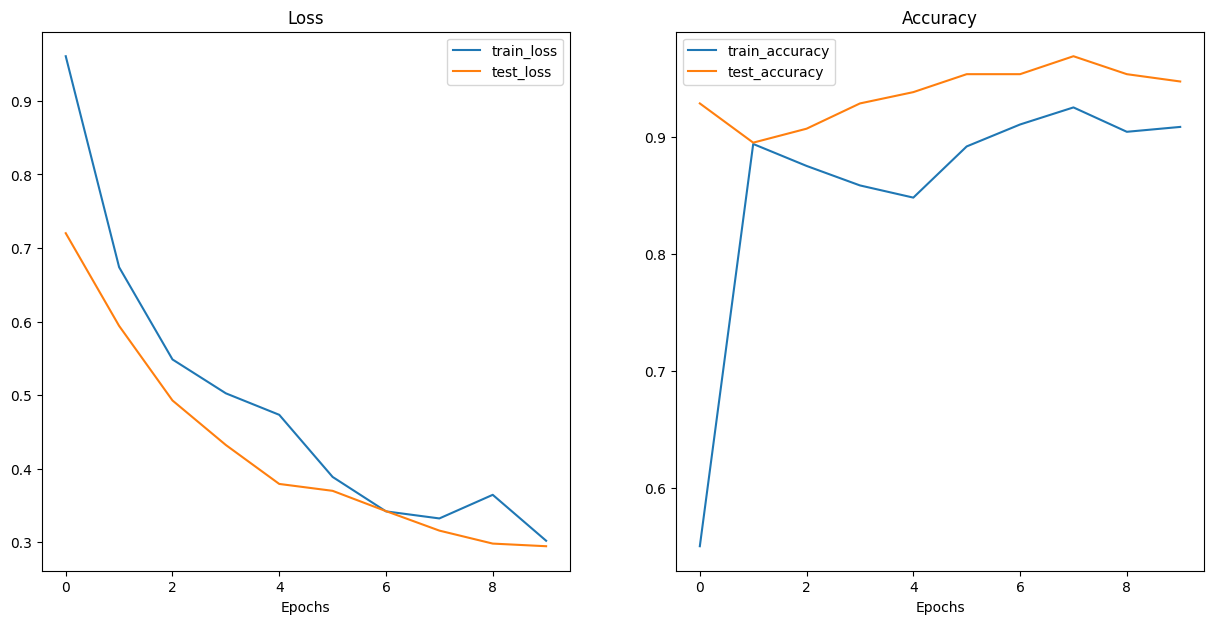

In [11]:
utils.plot_loss_curves(effnetb2_results)
utils.save_model_with_savetensors(model=effnetb2, model_name="09_pretrained_effnetb2_20_percent.safetensors")
effnetb2_model_size = utils.save_model(model=effnetb2, model_name="09_pretrained_effnetb2_20_percent.pth")
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_stats = {
    "test_loss": effnetb2_results["test_loss"][-1],
    "test_accuracy": effnetb2_results["test_acc"][-1],
    "number_of_parameters": effnetb2_total_params,
    "model_size": effnetb2_model_size
}

In [14]:
def create_vit_model(num_classes: int=3):
    """Creates a ViT-B/16 feature extractor model and transforms
    
    Args:
        num_classes: number of classes in the classifier head, defaults to 3
        
    Returns:
        model: ViT-B/16 feature extractor model
        transforms: EffNetB2 image transforms
    """
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    model.heads = nn.Linear(in_features=768, out_features=num_classes)

    return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model(num_classes=3)
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

vit_loss_fn = nn.CrossEntropyLoss()
vit_optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)
vit_results = engine.train(
    model=vit,
    train_dataloader=train_dataloader_vit,
    test_dataloader=test_dataloader_vit,
    loss_fn=vit_loss_fn,
    optimizer=vit_optimizer,
    device=device,
    epochs=10
)

Saving model to: /home/glauco/Desktop/projects/learningPyTorch/trained_models/09_pretrained_vit_20_percent.pth


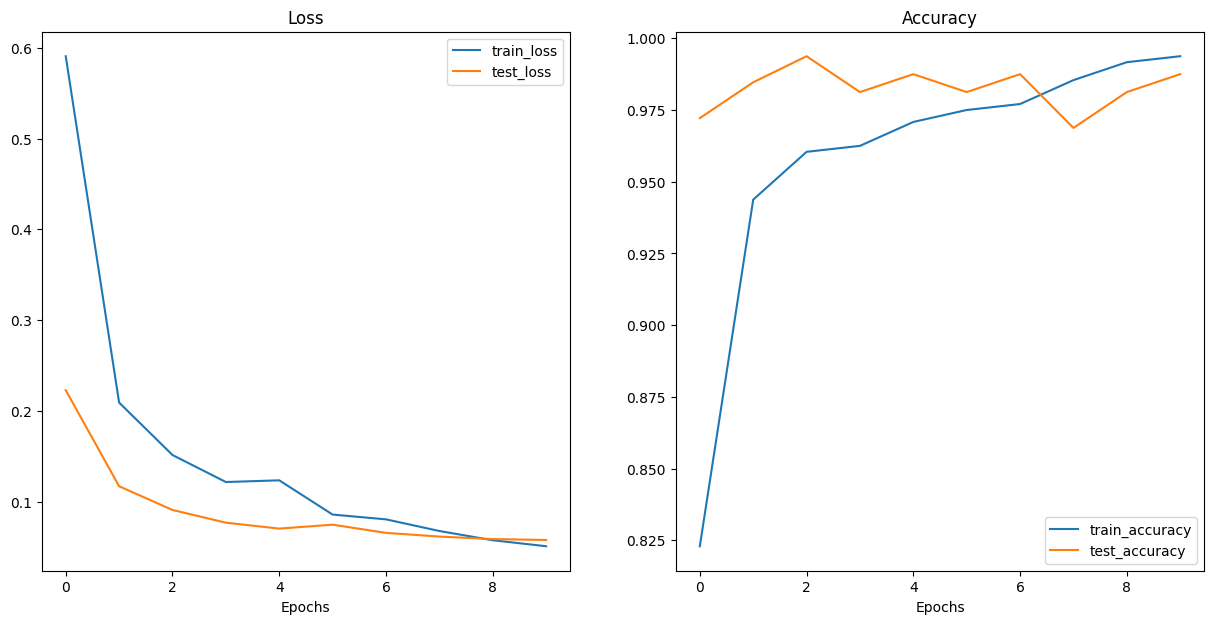

In [16]:
utils.plot_loss_curves(vit_results)
vit_model_size = utils.save_model(model=vit, model_name="09_pretrained_vit_20_percent.pth")
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_stats = {
    "test_loss": vit_results["test_loss"][-1],
    "test_accuracy": vit_results["test_acc"][-1],
    "number_of_parameters": vit_total_params,
    "model_size": vit_model_size
}

In [21]:
test_data_paths = list(test_dir.glob("*/*.jpg"))

effnetb2_test_pred_dicts = utils.pred_and_store(
    effnetb2,
    test_data_paths,
    effnetb2_transforms,
    class_names,
    torch.device("cpu")
)

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_stats["time_per_pred_cpu"] = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,/home/glauco/Desktop/projects/learningPyTorch/...,pizza,"[[tensor(0.9964), tensor(0.0023), tensor(0.001...",pizza,0.0348,True
1,/home/glauco/Desktop/projects/learningPyTorch/...,pizza,"[[tensor(0.8243), tensor(0.1099), tensor(0.065...",pizza,0.0320,True
2,/home/glauco/Desktop/projects/learningPyTorch/...,pizza,"[[tensor(0.9168), tensor(0.0397), tensor(0.043...",pizza,0.0319,True
3,/home/glauco/Desktop/projects/learningPyTorch/...,pizza,"[[tensor(0.9367), tensor(0.0230), tensor(0.040...",pizza,0.0346,True
4,/home/glauco/Desktop/projects/learningPyTorch/...,pizza,"[[tensor(0.9002), tensor(0.0278), tensor(0.072...",pizza,0.0289,True


In [22]:
vit_test_pred_dicts = utils.pred_and_store(
    vit,
    test_data_paths,
    vit_transforms,
    class_names,
    torch.device("cpu")
)

vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_stats["time_per_pred_cpu"] = round(vit_test_pred_df.time_for_pred.mean(), 4)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,/home/glauco/Desktop/projects/learningPyTorch/...,pizza,"[[tensor(0.9953), tensor(0.0024), tensor(0.002...",pizza,0.1347,True
1,/home/glauco/Desktop/projects/learningPyTorch/...,pizza,"[[tensor(0.9982), tensor(0.0007), tensor(0.001...",pizza,0.1168,True
2,/home/glauco/Desktop/projects/learningPyTorch/...,pizza,"[[tensor(0.9984), tensor(0.0008), tensor(0.000...",pizza,0.1243,True
3,/home/glauco/Desktop/projects/learningPyTorch/...,pizza,"[[tensor(0.9982), tensor(0.0010), tensor(0.000...",pizza,0.1094,True
4,/home/glauco/Desktop/projects/learningPyTorch/...,pizza,"[[tensor(0.9984), tensor(0.0006), tensor(0.000...",pizza,0.1119,True


In [31]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EffNetB2", "ViT-B/16"]
df["test_accuracy"] = round(df["test_accuracy"]*100, 2)
df

,test_loss,test_accuracy,number_of_parameters,model_size,time_per_pred_cpu,model
0,0.293805,95.40,7705221,29,0.0238,EffNetB2
1,0.057729,98.75,85800963,327,0.0985,ViT-B/16


In [36]:
pd.DataFrame(
    data=(df.set_index("model").loc["ViT-B/16"] / df.set_index("model").loc["EffNetB2"]),
    columns=["ViT to EffNet ratios"]
).T

,test_loss,test_accuracy,number_of_parameters,model_size,time_per_pred_cpu
ViT to EffNet ratios,0.196488,1.035115,11.135432,11.275862,4.138655


Ultimately, the decision is to deploy the EffNetB2, as for our application the 3% increase in accuracy isn't worth the extra size and latency